# Road Vehicles Platooning using Multi-Agent Reinforcement Learning
**Statistical Machine Learning Project**\
 **Prepared by: Charbel ABI HANA**

# Table of Contents


## Intro 

## Reinforcement Learning

## Multi-Agent Reinforcement Learning

## OpenAI GYM

## Highway Environment

### Envrionment Overview

![highway-env](data/highway-env.gif)
<div class="alert alert-block alert-success">
<b>Highway-v0-environment:</b> Multilane highway environment where ego/agent vehicles navigate at high speeds while avoiding collisions with neighbouring vehicles.
</div>

![highway-env](data/merge-env.gif)
<div class="alert alert-block alert-success">
<b>Merge-v0-environment:</b> ego/agent vehicles approach a merging lane as they are travelling on a highway. Merging lanes have other vehicles coming out to merge on highway and agents should avoid those cars. 
</div>

### Action Space

<div class="alert alert-block alert-info">
<b>DiscreteMetaAction:</b> <br>
    &emsp;<em>ACTIONS_ALL</em> = <br> 
    &emsp;{ <br>
        &emsp;&emsp;0: 'LANE_LEFT',<br>
        &emsp;&emsp;1: 'IDLE',<br>
        &emsp;&emsp;2: 'LANE_RIGHT',<br>
        &emsp;&emsp;3: 'FASTER',<br>
        &emsp;&emsp;4: 'SLOWER'<br>
    &emsp;}<br>
</div>


### Observation Space

### Reward Function

### Multi-Agent Layout

### IDQN - Independant Agents - Development

In [18]:
import os

os.listdir("highway-env")

['.git',
 '.github',
 '.gitignore',
 'CITATION.cff',
 'codecov.yml',
 'docs',
 'highway_env',
 'LICENSE',
 'pyproject.toml',
 'README.md',
 'scripts',
 'setup.cfg',
 'setup.py',
 'tests']

In [364]:
# Environment
import gym
from gym import wrappers

import highway_env

# Agent
from stable_baselines3 import DQN

# Visualization utils
import tensorboard
import sys
from tqdm.notebook import trange

In [3]:
%load_ext tensorboard

In [4]:
%tensorboard --logdir "highway_dqn"

Reusing TensorBoard on port 6006 (pid 6620), started 5:11:17 ago. (Use '!kill 6620' to kill it.)

In [514]:
import gym
import highway_env
import pfrl
import numpy as np
import torch
import torch.nn as nn

from typing import Tuple

from pfrl import explorers, replay_buffers
from pfrl.explorer import Explorer
from pfrl.agents import DQN
from pfrl.q_functions import DiscreteActionValueHead
from pfrl.utils.contexts import evaluating

In [366]:
env = gym.make('highway-v0')
env.seed(0)

[0]

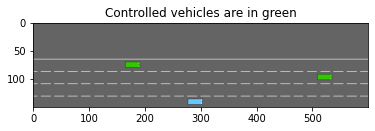

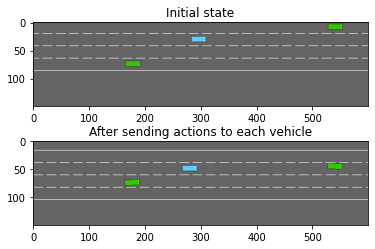

In [367]:
env.configure({"controlled_vehicles": 2})  # Two controlled vehicles
env.configure({"vehicles_count": 1})  # A single other vehicle, for the sake of visualisation
env.reset()

from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(env.render(mode="rgb_array"))
plt.title("Controlled vehicles are in green")
plt.show()

env.configure({
  "action": {
    "type": "MultiAgentAction",
    "action_config": {
      "type": "DiscreteMetaAction",
    }
  }
})
env.reset()

_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.imshow(env.render(mode="rgb_array"))
ax1.set_title("Initial state")

# Make the first vehicle change to the left lane, and the second one to the right
action_1, action_2 = 0, 2  # See highway_env.envs.common.action.DiscreteMetaAction.ACTIONS_ALL
env.step((action_1,action_2))

ax2.imshow(env.render(mode="rgb_array"))
ax2.set_title("After sending actions to each vehicle")
plt.show()

In [507]:
class Agent(object):
    def __init__(self):
        if torch.cuda.is_available():
            device = "cuda:0"
        else:
            device = "cpu"
        self.device = torch.device(device)

    def act(self, observation):
        raise NotImplementedError

    def observe(self, observation, reward, done, info):
        raise NotImplementedError


class IndependentAgent(Agent):
    def __init__(self, config, obs_act):
        super().__init__()
        self.config = config
        self.agents = dict()

    def act(self, observation):
        acts = dict()
        for agent_id in observation.keys():
            acts[agent_id] = self.agents[agent_id].act(observation[agent_id])
        return acts

    def observe(self, observation, reward, done, info):
        for agent_id in observation.keys():
            self.agents[agent_id].observe(observation[agent_id], reward[agent_id], done, info)
            if done:
                if info['eps'] % 100 == 0:
                    self.agents[agent_id].save(self.config['log_dir']+'agent_'+agent_id)

In [515]:
class DQNAgent(Agent):
    def __init__(self, config, act_space, model):
        super().__init__()

        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters())
        replay_buffer = replay_buffers.ReplayBuffer(10000)


        explorer = explorers.LinearDecayEpsilonGreedy(
            config['EPS_START'],
            config['EPS_END'],
            config['steps'],
            lambda: np.random.randint(act_space),
        )

        self.agent = DQN(self.model, self.optimizer, replay_buffer, config['GAMMA'], explorer,
                         gpu=self.device.index,
                         minibatch_size=config['BATCH_SIZE'], replay_start_size=config['BATCH_SIZE'],
                         phi=lambda x: np.asarray(x, dtype=np.float32),
                         target_update_interval=config['TARGET_UPDATE'])

    def act(self, observation):
        return self.agent.act(observation)

    def observe(self, observation, reward, done, info):
        self.agent.observe(observation, reward, done, False)

    def save(self, path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path+'.pt')

In [516]:
class IDQN(IndependentAgent):
    def __init__(self, config, obs_act):
        super().__init__(config, obs_act)
        for key in obs_act:
            obs_space = obs_act[key][0]
            act_space = obs_act[key][1]

            def conv2d_size_out(size, kernel_size=2, stride=1):
                return (size - (kernel_size - 1) - 1) // stride + 1

            h = conv2d_size_out(obs_space[1])
            w = conv2d_size_out(obs_space[2])

            model = nn.Sequential(
                nn.Conv2d(obs_space[0], 64, kernel_size=(2, 2)),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(h * w * 64, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, act_space),
                DiscreteActionValueHead()
            )

            self.agents[key] = DQNAgent(config, act_space, model)

In [517]:
def develop_observations(env_obs: Tuple[np.ndarray]):
    return {f"vehicle_{i}":obs[np.newaxis] for i, obs in enumerate(env_obs)}

In [518]:
config = {'BATCH_SIZE': 32,
'GAMMA': 0.99,
'EPS_START': 1.0,
'EPS_END': 0.0,
'TARGET_UPDATE': 500,
'steps': 1.0,
'log_dir': 'idqn_logs/'}

In [519]:
controlled_vehicles = 3
actions = 5
observation_space_batched = (1, 5, 5)
obs_act = {f"vehicle_{i}":(observation_space_batched, actions) for i in range(controlled_vehicles)}
obs_act

{'vehicle_0': ((1, 5, 5), 5),
 'vehicle_1': ((1, 5, 5), 5),
 'vehicle_2': ((1, 5, 5), 5)}

In [520]:
alg = IDQN(config= config, obs_act= obs_act)

In [521]:
# Multi-agent environment configuration
env.configure({
  "controlled_vehicles": controlled_vehicles,
  "observation": {
    "type": "MultiAgentObservation",
    "observation_config": {
      "type": "Kinematics",
    }
  },
  "action": {
    "type": "MultiAgentAction",
    "action_config": {
      "type": "DiscreteMetaAction",
    }
  }
})

In [537]:
# 100 training episodes
for i in range(100):
    obs = env.reset()
    developed_obs = develop_observations(obs)
    done = False
    while not done:
        # Dispatch the observations to the model to get the tuple of actions
        action = alg.act(developed_obs)
        full_action = (action_disc for _, action_disc in action.items())
        # Execute the actions
        next_obs_full = []
        rewards = {}

        infos = {"speed": [], "crashed": [], "action": [], "cost": [], "eps": 0}
        for i, action in enumerate(full_action):
            action_list = [1 for _ in range(controlled_vehicles)]
            action_list[i] = action
            next_obs, reward, done, info = env.step(tuple(action_list))
            rewards[f"vehicle_{i}"] = reward
            infos["speed"].append(info["speed"])
            infos["crashed"].append(info["crashed"])
            infos["action"].append(info["action"][0])
            infos["cost"].append(info["cost"])
        infos["eps"] += 1
        next_obs_full.append(next_obs[i])
        next_obs_full = develop_observations(tuple(next_obs_full))
        # Update the model with the transitions observed by each agent
        alg.observe(next_obs_full, rewards, done, infos)

[[1. 1. 1.]]
[[1. 1. 1.]]
[[1. 1. 1.]]


In [500]:
b = list(a)
b.insert(0, 0)

In [533]:
b = {}

In [534]:
b["A"] = b["A"] + 1

KeyError: 'A'